In [29]:
%matplotlib inline

'''
Use %matplotlib inline instead of %matplotlib widget when preparing the final report. 
Otherwise the images are, unfortunately, not embedded in the pdf. 
'''
from importstatements import *
css_styling()

$
\newcommand{\fsamp}{{F_s}}
\newcommand{\tsamp}{{T_s}}
\newcommand{\unit}[1]{\text{\,#1}}
\newcommand{\tmidx}{n}
\newcommand{\tds}[2][\tmidx]{{#2(#1)}}
\newcommand{\matcmd}[2][(\cdot)]{\texttt{#2}#1}
\renewcommand{\matcmd}[2][(\cdot)]{\mathrm{#2}#1}
\newcommand{\fcn}[1]{{\text{#1}}}
\newcommand{\bigcb}[1]{{\big\{#1\big\}}} 
\newcommand{\Bigcb}[1]{{\Big\{#1\Big\}}}
\newcommand{\bigsb}[1]{{\big[#1\big]}} 
\newcommand{\Bigsb}[1]{{\Big[#1\Big]}}
\newcommand{\biggsb}[1]{{\bigg[#1\bigg]}}
\newcommand{\pyt}{\matcmd[]{Python}}
\newcommand{\fds}[2][z]{#2(#1)}
\newcommand{\zpow}[1][-1]{z^{#1}}
\newcommand{\cbr}[1]{\big\{#1\big\}}
\newcommand{\mat}[1]{\boldsymbol{#1}}
\newcommand{\idxa}{k}
$

# FIR filter design and adaptive filters

In this lab session you will become further acquainted with common filtering operations and filters we have seen in the lecture. The contents of this exercise are the following:
* design of simple FIR filters by the methods discussed in the lecture 
* programming a simple adaptive filter to remove an interfering noise from a target signal, when a reference signal of the interference is available.

---------

## Simple design of FIR filters

As seen in the lecture, sometimes, we have the filter impulse response available to us as a closed-form mathematical equation. Then we can directly use this to generate the filter. Let us now look at this way to generate the standard filters we can use in our signal processing tasks. 

Let us experiment first with a simple low-pass filter (LPF).


### Method 1: Sampling the analogue impulse response in time domain

<div class="alert alert-info">

We shall now write a function `td_lpf(N,BTs)` to design a low-pass filter where
    
* $2N+1$: is the number of taps of this filter and 
* `BTs` is the normalised bandwidth of the filter. 
  
Follow the design procedure for the time-domain derivation of the filter (i.e., the impulse response) and the practical implementation as follows:
    
**Tasks**

* Theory: Determine the impulse response of an ideal digital LPF with $H(fT_s) = 1$ in $fT_s \in (-BT_s/2, BT_s/2)$ and zero beyond (*Tip: calculate the (inverse) Fourier transform of this rectangular function. You should see that this corresponds to a sinc function extending from $n = -\infty$ to $n = \infty$*). Write your obtained expression below.
    
</div>

<div class="alert alert-success">

First derive the theoretical inverse Fourier transform

\begin{align}
     h_a(t) &= \mathcal{F}^{-1}[H](t)\\
    &=\int_{-\infty}^{+\infty}H(fT_s)e^{j2\pi ft}df\\
    &=\int_{\frac{BT_s}{2T_s}}^{-\frac{BT_s}{2T_s}}e^{j2\pi ft}df\\
    &=\frac{e^{j2\pi \frac{BT_s}{2T_s}t}-e^{-j2\pi \frac{BT_s}{2T_s}t}}{j2\pi t}\\
    &=\frac{\sin(\pi \frac{BT_S}{T_s}t)}{\pi t}\\
    &=\frac{BT_s}{T_s}\text{sinc}\left(\frac{BT_s}{T_s}t\right)
\end{align}

Sampling scales the spectrum and thus needs to be compensated: $h(n)=T_sh_a(t)|_{t=nT_s}$. The impulse response of the ideal digital LPF becomes 
$$\tds{h} = BT_S\text{sinc}(BT_sn)$$


</div>

<div class="alert alert-info">

* Select from these infinite number of taps, an interval of length $2N + 1$ (since we cannot have unlimited length filters in a practical realisation). 
* Design the filter and plot the resulting impulse and frequency response for `N=128` and `BTs= 1/4`. In order to calculate the frequency response, use the `fft.fft` function.
* How can you check your design is correct? Answer briefly why in the space below.
    
</div>

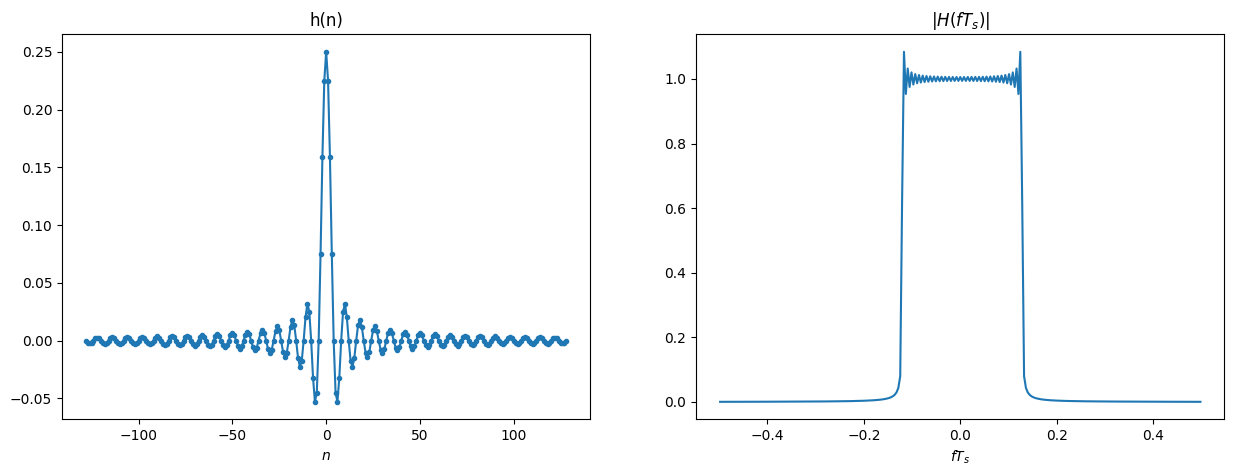

In [30]:
# Function
def td_lpf(N,BTs):
    n = np.arange(-N,N+1)
    h = lambda n: BTs*np.sinc(BTs*n)
    return h(n), n

# Plotting of impulse and amplitude response
N, BTs = 128, 1/4
fTs = fft.fftshift(fft.fftfreq(2*N+1))
h, n = td_lpf(N,BTs)
H = fft.ifftshift(fft.fft(h))

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

ax1.plot(n,h,marker='o',ms=3)
ax1.set_xlabel('$n$')
ax1.set_title('h(n)')

ax2.plot(fTs, abs(H))
ax2.set_xlabel('$fT_s$')
ax2.set_title('$|H(fT_s)|$')

h_time,n_time,fTs_time,H_time = h,n,fTs,H


<div class="alert alert-success">
    
How do you verify the correctness of your design?

The frequency response computed from the implemented impulse response comes close to the original frequency response, i.e. $H(fT_s)=1$ in $fT_s \in (-BT_S/2,BT_s/2)$ and zero beyond which indicates a good design.

</div>

#### Gibbs' phenomenon and its reduction

You will observe Gibbs' phenomenon due to the abrupt truncation of the impulse response. We know that windowing the truncated impulse response with a smoothly tapering windown can reduce this effect. 

<div class="alert alert-info">

* Consequently: modify your previous function to apply a von Hann window. Call this new function `td_lpf_win(N,BTs)`
* Re-design the previous LPF with this new function, compare the impulse and amplitude response obtained with that of the previous design. Note your observations regarding the differences in:
    * width of passband and stopband
    * behaviour of the impulse response
* What do you think would be the phase response of these filters? Will they be linear phase? Justify your answer (without actually plotting the phase response!)
* Are the designed filters causal? Justify!
    
</div>    

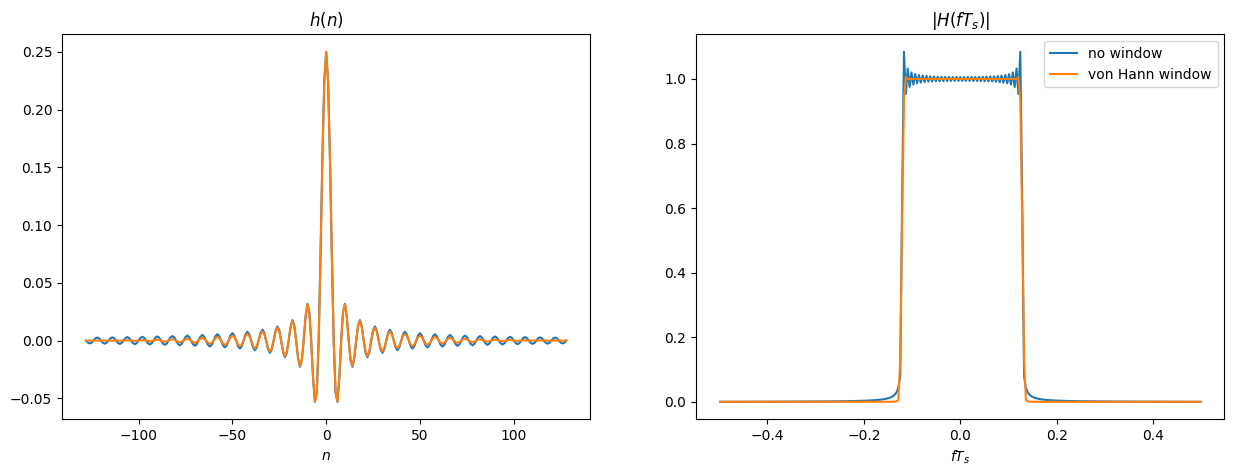

In [31]:
# Function
def td_lpf_win(N,BTs):
    n = np.arange(-N,N+1)
    h = lambda n: BTs*np.sinc(BTs*n)
    w = np.hanning(2*N+1)
    return w*h(n), n

# Example filter design for given specifications
# Plotting of impulse and amplitude respons
hWin, n = td_lpf_win(N,BTs)
HWin = fft.ifftshift(fft.fft(hWin))

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

ax1.plot(n,h,label='no window')
ax1.plot(n,hWin,label='von Hann window')
ax1.set_xlabel('$n$')
ax1.set_title('$h(n)$')

ax2.plot(fTs, abs(H),label='no window')
ax2.plot(fTs, abs(HWin),label='von Hann window')
ax2.set_xlabel('$fT_s$')
ax2.set_title('$|H(fT_s)|$')
#ax2.set_ylim([0.8,1.1])
#ax2.set_xlim([-0.2,0.2])

plt.legend()

# Comparison with `td_lpf`

<div class="alert alert-success">
    
* Notes on comparison of the windowed and non-windowed LPF design.

The impulse response of the windowed signal dies out for $n$ going to -128 and 128, which is expected using the von Hann window. The windowed frequency response is less affected by the gibbs effect, there are less oscillations. However, the tapered window broadens the transition region, narrowing the passband. The stopband on the other hand is broader than without the use of a window.

* Discussion on the nature of the phase response

For the ideal LPF with $H(fT_s) = 1$ in $fT_s \in (-BT_s/2, BT_s/2)$ and zero beyond the phase remains $0$, i.e. $H(fT_s)$ is real and positive, hence one can speak of a linear phase. Linear filters have a symmetry about its centre. Since both $BT_s sinc(BT_sn)$ and $w_{hann} BT_s sinc(BT_sn)$ are symmetrical about their centre, the filters have a linear phase response.

* Comments on the causal/non-causal nature of the impulse response

The filters are non-causal since their impulse response isn't equal to zero for negative n-values.

</div>    

### Method 2: FIR filter design by frequency response sampling

Now we shall obtain the filter impulse response by directly sampling the desired filter characteristics in the frequency domain. This allows us to design filters where no closed-form equation can be obtained for the impulse response. We shall also see, here, what the pitfalls of this simple approach are and how to avoid them.

We shall write a function `fd_lpf(N,BTs)` to design a low-pass filter where:

* Now, $2N$ is the number of taps of this filter (note difference with time-domain) and 
* `BTs` is the normalised bandwidth of the filter. We are only concerned with the amplitude response in this case. Follow the design procedure below: 

<div class="alert alert-info"> 
    
**Task**

* The basic idea is to sample the desired amplitude response in $fT_s\in[0,1/2]$ using $N+1$ *equispaced* sampling points on the frequency axis. Note that both $f=0$ and $f=F_s/2$ should be sampled. This forms the $(N+1)$-point discrete version of the desired amplitude spectrum for the positive frequencies. 
* What is the (normalised) frequency interval $\Delta_{f}T_s$ between two sampling points?
    
</div>    

<div class="alert alert-success">
    
(Normalised) frequency interval between 2 sampling points is: $\Delta_fT_s = \frac{1}{2N}$
    
</div>

<div class="alert alert-info">
    
* Now, form the amplitude spectrum for the $N-1$ *negative* frequencies $fT_s\in[-\Delta_fT_s,-1/2+\Delta_fT_s]$ by using the properties of the Fourier transform $X(-f)=X^{\ast}(f)$ for real-valued signals.
* Since we will use the IDFT to compute the inverse transform of this spectrum, place the negative frequency elements in the right place for computing the IDFT: i.e. $X(-k)=X(2N-k)$. This should give you an $2N-$ dimensional vector. Compute the IDFT of this vector. If you have done everything correctly, this should be purely real-valued.
* Ideally, this should be the impulse response you are looking for.

First write the function `fd_lpf(N,BTs)` based on this schematic.   
    
</div>

In [32]:
# Function for the frequency sampled filter design
# Some check-points to ensure you are going in the correct direction
# - Is N a power of 2? (Efficient for the (i)FFT computations)
# - Is the length of the frequency domain vector that you generated the same as N?


def fd_lpf(N,BTs):

    # positive frequencies
    fTspos = np.linspace(0, 1/2, N+1)
    Hpos = np.where(fTspos <= BTs, 1, 0)

    # negative frequencies
    fTsStep = 1/(2*N)
    fTsneg = np.linspace(-1/2+fTsStep, -fTsStep, N-1)
    Hneg = np.where(np.abs(fTsneg) <= BTs, 1, 0)

    H = np.concatenate((Hneg, Hpos))

    n, h = np.linspace(-N+1,N, 2*N), fft.ifft(H)
    
    return n, h



<div class="alert alert-info">
    
* Design the filter based on your code for $BTs=0.25$ and $N=128$. Plot the amplitude and impulse response. Verify your design is correct.
    
</div>

Text(0.5, 1.0, '$|H(fT_s)|$')

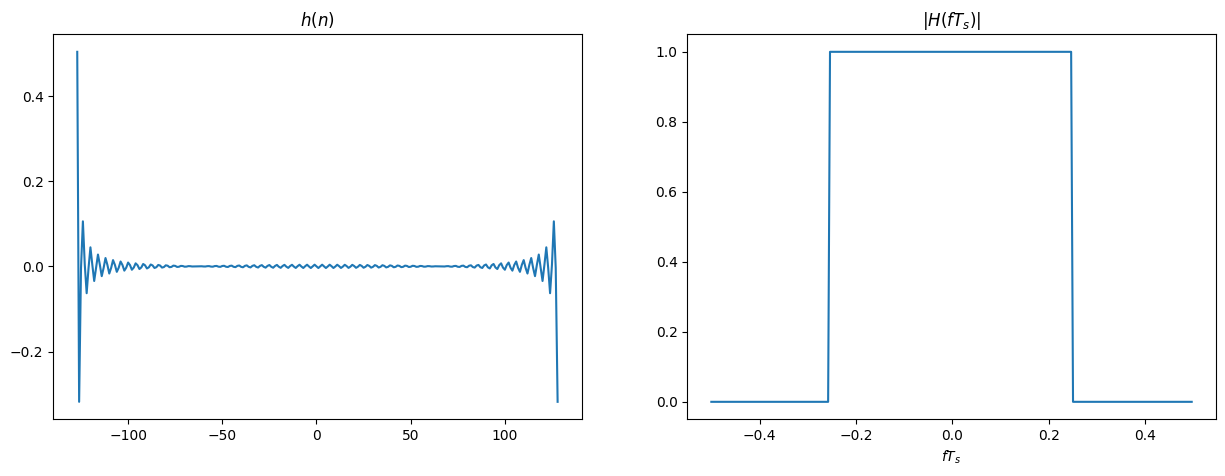

In [33]:
# Code: design and verification of the filter design using the 
# frequency sampling approach
N, BTs = 128, 0.25
n, h = fd_lpf(N, BTs)

fTs = fft.fftshift(fft.fftfreq(h.size))
H = fft.fft(h)

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

ax1.plot(n,h)
ax1.set_title('$h(n)$')

ax2.plot(fTs, abs(H))
ax2.set_xlabel('$fT_s$')
ax2.set_title('$|H(fT_s)|$')

<div class="alert alert-info">
    
* Since we are essentially designing an FIR filter with the same characteristics as in the previous problem (i.e., `td_lpf`), the frequency response and impulse response should be similar. Are they? 
* Does a comparison of the amplitude response indicate why (if at all) there are deviations?
    
</div>

<div class="alert alert-success">
    
* Comparison of frequency sampling vs time-domain design. Is the impulse response the same. (or similar to) the `td_lpf` design?
* What about the amplitude response?
* Why do you think there are deviations (if any) between the `fd_lpf` and the `td_lpf` output?

The impulse response looks shifted. The maximum value, that would be expected to lie at the center, is now located at the most left position. Moreover using the `fd_lpf` design results in sharper peaks and a narrower "center" (now not located at the center) in comparison with the `td_lpf` design. This because higher frequencies are forced to be included in the `fd_lpf` design, i.e the full proposed bandwith was included, instead of the `td_lpf` design where the effective bandwidth is smaller then the proposed one. This difference in bandwith can clearly be seen when compairing the amplitude responses of the two designs.

</div>    

This behaviour is because the filter returned by the IDFT is an acausal filter, but, because the IDFT also results in a periodic repetition of the signal along the time-axis, the filter coefficients $h(-n)$ for *negative time indices* are given by coefficients $h(N-n)$. Therefore, we need to *rotate* the resulting filter by $N/2$ to obtain a causal filter of the true form. A way to do this is to use the command `fftshift` after the inverse DFT on the time-domain filter.

<div class="alert alert-info">
    
* Plot the impulse response of the filter after the rotation. Verify that the amplitude response has not changed. 
    
</div>    

/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


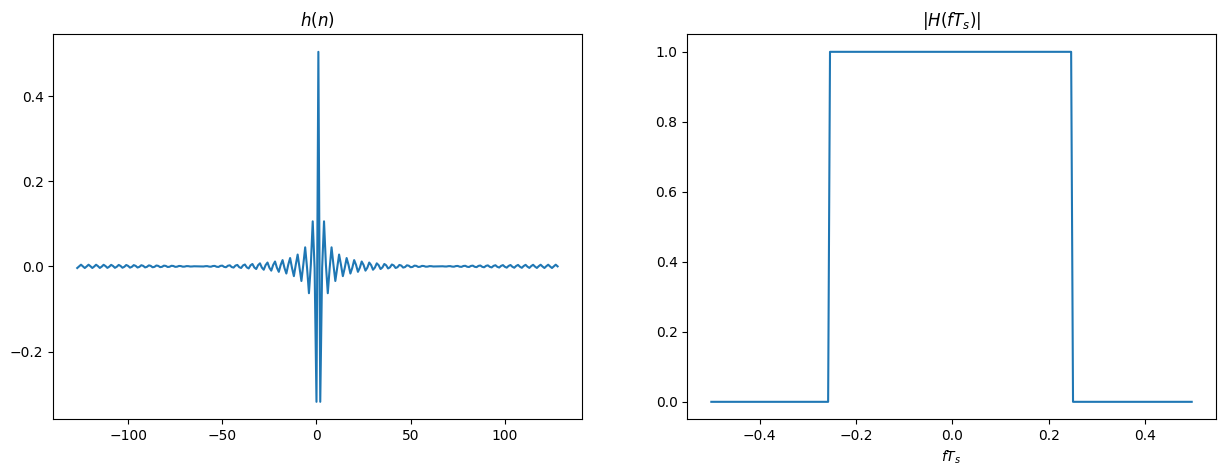

In [47]:
# Impulse and amplitude response of "time-rotated" filter

N, BTs = 128, 0.25
n, h = fd_lpf(N, BTs)
h = fft.fftshift(h)
zeros = np.zeros(50)
h_padded = np.concatenate((zeros, h, zeros))
n_padded = np.linspace(-N-49,N+50, 2*(N+50))

fTs = fft.fftshift(fft.fftfreq(h.size))
H = fft.fft(h)
fTs_padded = fft.fftshift(fft.fftfreq(h_padded.size))
H_padded = fft.fft(h_padded)

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

ax1.plot(n, h)
ax1.set_title('$h(n)$')

ax2.plot(fTs, abs(H))
ax2.set_xlabel('$fT_s$')
ax2.set_title('$|H(fT_s)|$')

h_freq,n_freq,fTs_freq,H_freq,fTs_padded_freq,H_padded_freq = h,n,fTs,H,fTs_padded,H_padded

<div class="alert alert-info">
    
* What do you now conclude between the frequency-sampling and the time-domain design?
* Also: is the LPF filter you designed using `fd_lpf` a linear phase filter? Answer without explicitly calculating the phase response. _Tip_ The impulse response of a linear phase filter has symmetry about its center. Think carefully about this!
    
</div>

Text(0.5, 1.0, '$|H(fT_s)|$ - frequency domain')

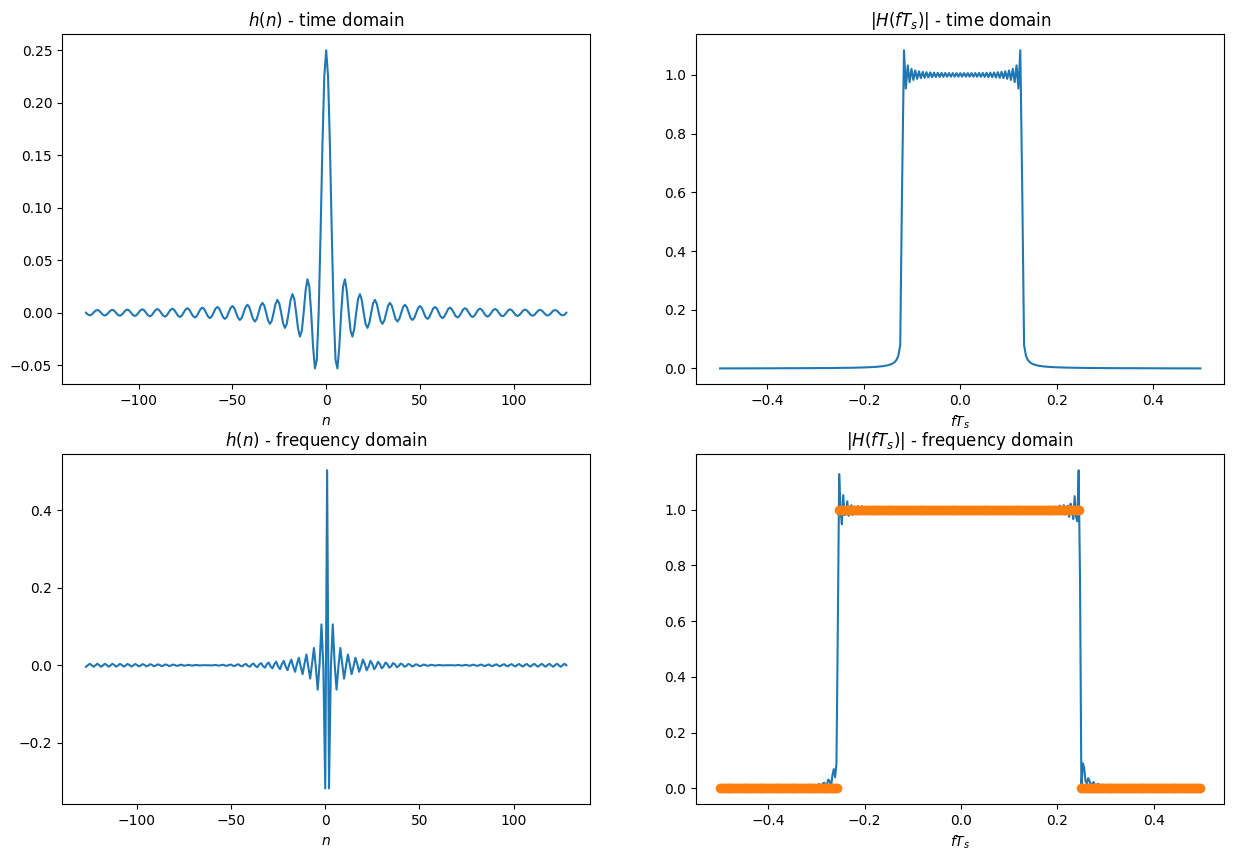

In [48]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
ax[0][0].plot(n_time,h_time)
ax[0][0].set_xlabel('$n$')
ax[0][0].set_title('$h(n)$ - time domain')

ax[0][1].plot(fTs_time, abs(H_time))
ax[0][1].set_xlabel('$fT_s$')
ax[0][1].set_title('$|H(fT_s)|$ - time domain')

ax[1][0].plot(n_freq,h_freq)
ax[1][0].set_xlabel('$n$')
ax[1][0].set_title('$h(n)$ - frequency domain')

ax[1][1].plot(fTs_padded_freq, abs(H_padded_freq))
ax[1][1].plot(fTs_freq, abs(H_freq),'o')
ax[1][1].set_xlabel('$fT_s$')
ax[1][1].set_title('$|H(fT_s)|$ - frequency domain')

<div class="alert alert-success">
    
* Your answer/observations 

The impulse response in the time-domain sampling method is larger than in the frequency domain method. The amplitude response in the frequency domain method is  more similar to the ideal rectangular pulse.

The impulse response is symmetrical about its centre, which indicates that it concerns a linear phase filter.
    
</div>

#### Reducing Gibbs' phenomenon

You will note that this filter design still shows oscillations at the transition regions. We saw, in the lecture, that this is related to the sharp transitions between the stopband and passband. We also saw two means to mitigate this: (1) by windowing the impulse response and (2) by making the transition soft in the desired frequency response (i.e., by modifying the $H(fT_s)$ directly to have a broader transition band. 


<div class="alert alert-info">   

**Task**
    
* Implement the second method as the function `fd_lpf_soft(N,BTs)` by setting the last sample in the pass-band to 0.8 and first sample in stop-band to 0.2. Do not forget to "rotate" the filter after the IDFT. 
* Compare this filter to that obtained using `td_lpf_win` for the same LPF specifications we have considered so far (impulse and amplitude response). Briefly summarise your observations.  

</div>

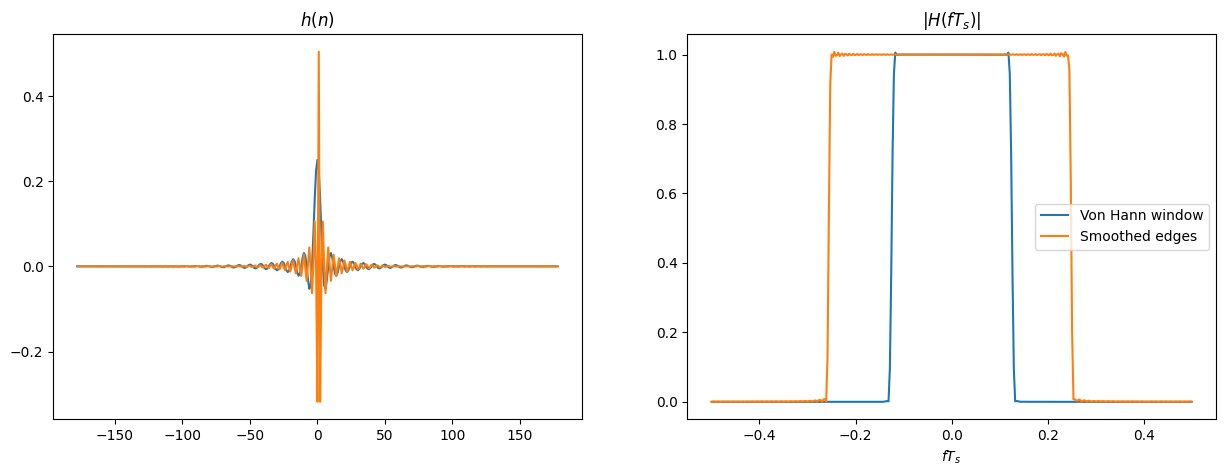

In [50]:
# Frequency-domain design with soft transition bands
def fd_lpf_soft(N,BTs):
    fTsStep = 1/(2*N)

    # positive frequencies
    fTspos = np.linspace(0, 1/2, N+1)
    Hpos = np.where(fTspos <= BTs, 1.0, 0.0)
    Hpos[np.where(Hpos == 1)[0][-1]] = 0.8
    Hpos[np.where(Hpos == 0)[0][0]] = 0.2

    # negative frequencies
    fTsneg = np.linspace(-1/2+fTsStep, -fTsStep, N-1)
    Hneg = np.where(np.abs(fTsneg) <= BTs, 1.0, 0.0)
    Hneg[np.where(Hneg == 1)[0][0]] = 0.8
    Hneg[np.where(Hneg == 0)[0][-1]] = 0.2
    
    H = np.concatenate((Hneg, Hpos))

    n, hSoft = np.linspace(-N+1,N, 2*N), fft.fftshift(fft.ifft(H)) 

    return hSoft

# Filter design, amplitude response plot, comparison to `td_lpf_win`
N, BTs = 128, 0.25
hwin, nwin = td_lpf_win(N, BTs)
#hwin = fft.fftshift(hwin)
hSoft = fd_lpf_soft(N, BTs)
zeros = np.zeros(50)
hwin = np.concatenate((zeros, hwin, zeros))
hSoft = np.concatenate((zeros, hSoft, zeros))
n = np.linspace(-N-49,N+50, 2*(N+50))
nwin = np.linspace(-N-50,N+50, 2*(N+50)+1)

fTswin = fft.fftshift(fft.fftfreq(hwin.size))
fTsSoft = fft.fftshift(fft.fftfreq(hSoft.size))
Hwin = fft.fftshift(fft.fft(hwin))
HSoft = fft.fft(hSoft)

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

ax1.plot(nwin, hwin, label='Von Hann window')
ax1.plot(n, hSoft, label='Smoothed edges')
ax1.set_title('$h(n)$')

ax2.plot(fTswin, abs(Hwin), label='Von Hann window')
ax2.plot(fTsSoft, abs(HSoft), label='Smoothed edges')
ax2.set_xlabel('$fT_s$')
ax2.set_title('$|H(fT_s)|$')

plt.legend()

<div class="alert alert-success">
    
Observations

?The smoothed edges filter has an impulse response with a larger maximal peak, but it dies out faster?
The Von Hann window indirectly reduces the sharp transitions in the frequency domain and leads directly to a shorter effective impulse response. The smoothed edges filter on the other hand directly reduces sharp transitions in the frequency domain and indirectly leads to a shorter effective impulse response.
    
</div>

-----------

## Adaptive filtering for noise cancellation

### Getting a feel for an adaptive filter

Assume we have a signal $x(n)$ which consists of a desired signal component $s(n)$ and an interfering signal component $v(n)$. The model is: $x(n) = s(n) + v(n)$.

Assume, further, that the interfering signal $v(n)$ is generated by an *unknown* system $h^{\prime}(n)$, acting on the signal $v^{\prime}(n)$ i.e., $v(n) = h^{\prime}(n)\ast v^{\prime}(n)$. We have the signal $v^{\prime}(n)$ and we wish to use this to design an adaptive filter to *cancel* $v(n)$ in $x(n)$. 


1. We define an $M-$tap adaptive filter $\mathbf{h} = [h_0,h_1,\ldots,h_{M-1}]$. This is the FIR adaptive filter, which we shall use to estimate the unknown system $h^{\prime}(n)$
2. Start with some initial estimate of $\mathbf{h}$. E.g., all zeros or all ones or random values. It does not matter.
3. Now, iterate through the samples $\tmidx$ of the signal to adapt the filter. This is done as follows. For *each* sample $\tmidx$:
  1. let $\tds{\mat{h}}$ be the *estimate* of the adaptive filter at that time instant.
  2. compute the estimate ($\widehat{v}(n)$) of $\tds[n]{v}$, i.e, $\widehat{v}(n) = \sum_{k}h_{k}(n) \tds[\tmidx-\idxa]{v^{\prime}}$
  3. compute the error signal $\tds{r} = \tds[n]{x}-\widehat{v}(n)$. Note that this error is *biased* by the desired signal component $\tds[n]{s}$. However, since $\tds[n]{s}$ and $\tds[n]{v}$ are usually uncorrelated with each other, this bias usually does not affect the estimate of $h^{\prime}(n)$ much if a small step-size is chosen in the update rule.
  4. by the method of stochastic gradient (specifically, NMLS), use this error signal to compute the updated filter $\tds[\tmidx+1]{{\mat{h}}}$, to be used for the next sample. **Tip:** Take proper precautions to prevent divide-by-zero errors!
  4. The quality of the estimate $\widehat{\mat{h}}$ and the resulting output signal $\tds{\widehat{s}} = \tds{r}$ depends, quite strongly, on the parameters chosen for the NLMS. These parameters are: the stepsize $\alpha$ and the filter length $M$. You might need to play with these to get the best results.

<div class="alert alert-info">

**Task**
    
Implement the code for such a filter based on the above steps. The filter should receive as input the entire signal $\tds{x}$, $\tds{v^{\prime}}$, $\alpha$ and $M$. It should output the estimate of the unknown system $\mat{h}$ and the enhanced signal $\tds{\widehat{s}} = \tds{r}$.  

Use the code template given below. To make it even easier (lucky you!) some kind soul has written most of the code. You only have to fill in the missing signals (indicated by \<??\>).
    
</div>
    
_Tip:_ Our goal here is _identical_ to what we have seen in the lecture. So, as a first step, relate the signal variables given here to the signal variables of the condition we considered in the lecture. Sketching a block diagram may help.
    

 

In [51]:
def NLMSCanceller(x, vprime, alpha, M):

    N = len(x) # Number of samples in the signal.
    hEst = np.zeros(M) # Initialising the filter with zeros
    sEst = np.empty(N)  # Estimation of the enhanced output signal
    vHat = np.empty(N)  # Estimation of the interference
    
    # Ensure that vprime and x are of same length. If not, extend the shorter
    # signal with zeros to match the length of the longer signal.
    
    if N < vprime.size:
        x = np.concatenate((x,np.zeros(vprime.size-N)))
    elif N > vprime.size:
        vprime = np.concatenate((vprime,np.zeros(N-vprime.size)))
    
    # Process loop
    
    # Iterate through the signal, sample by sample

    sigBuf = np.zeros(M) # This is the buffer for the signal that will be filtered by hEst.
    # Since hEst is an FIR filter and because the convolution will be done sample-by-sample, it is easy to
    # represent the signals as vectors since the sample-wise convolution is simply a vector inner product.
    # In this buffer notation, the last samples in the buffer correspond to the "oldest" samples and the first samples
    # correspond to the most recent samples.
    # You are free to implement it differently!
    
    for sampC in range(N):
        # Add the new sample to the start of the reference signal buffer
        sigBuf[1:M] = sigBuf[0:M-1]
        sigBuf[0] = vprime[sampC] # Fill in the correct signal to be used here.

        # Filter this signal buffer with the filter hEst. Since we are doing this sample by sample,
        # the filtering is simply an inner product of the vectors hEst and sigBuf. Implement this inner product
        # using the dot() operator of a numpy array
        vHat[sampC] = np.dot(hEst, sigBuf) # <dot product of hEst and sigBuf> 

        # Compute the error signal
        sEst[sampC] = x[sampC] - vHat[sampC]

        # Update the filter. Take proper care to ensure that no divde-by-zero errors can occur
        # Some variables in the code below are missing. Fill them in. 
        # The expression below updates all samples of the filter at once (benefit of vector operations).
        # If you are not comfortable with this, feel free to re-write this for updating each tap of the filter separately.
        E = np.sum(sigBuf**2)
        if E == 0:
            E = 1
        hEst = hEst + 2*alpha*sEst[sampC]*(sigBuf)/(E)

    return hEst, sEst

### Sanity check on the implementation

In practice, before we deploy our algorithms in the "wild", we should appropriately test our implementations on data where we _know what the correct result should be_. This will convince us of the "correctness" of our implementation and alert us to any problems in our algorithm. Let us do the same for the adaptive filter we just designed.

<div class="alert alert-info">

1. Generate a signal `vprime = np.random.randn(10000)`
2. Generate the signal $\matcmd[]{x}$ as: `x = np.append(np.zeros(3), vprime[:-3])`
    
</div>

In [52]:
# Code cell
vprime = np.random.randn(10000)
x = np.append(np.zeros(3), vprime[:-3])

<div class="alert alert-info">    
Now answer the following questions:

1. You can clearly see, in step 2 above, that $\tds{x}$ is a filtered version of $\tds{v^{\prime}}$. What filter $\tds{h^{\prime}}$ does this correspond to?
2. What should you obtain as $\matcmd[]{hEst}$ in the ideal case?
3. What should $\matcmd[]{sEst}$ be, if the filter correctly estimated?
    
</div>    

<div class="alert alert-success">
    
Your answer/observations/conclusions here.

It is a shifting filter and in this case it delays the signal, hence in the ideal theoretical case hEst should be a shifted dirac function: $h'(n)=\delta(t-3)$ so that

$$x(n)=v(n)=v'*\delta(n-3).$$

This means that in the theoretical case sEst should be equal to zero.

<div class="alert alert-info">
    
4. Apply your `NLMSCanceller()` function to this data. Plot your results ($\matcmd[]{hEst}$ and $\matcmd[]{sEst}$) for $\alpha=\cbr{0.1,0.25,0.5}$. Comment on the results.
    
</div>

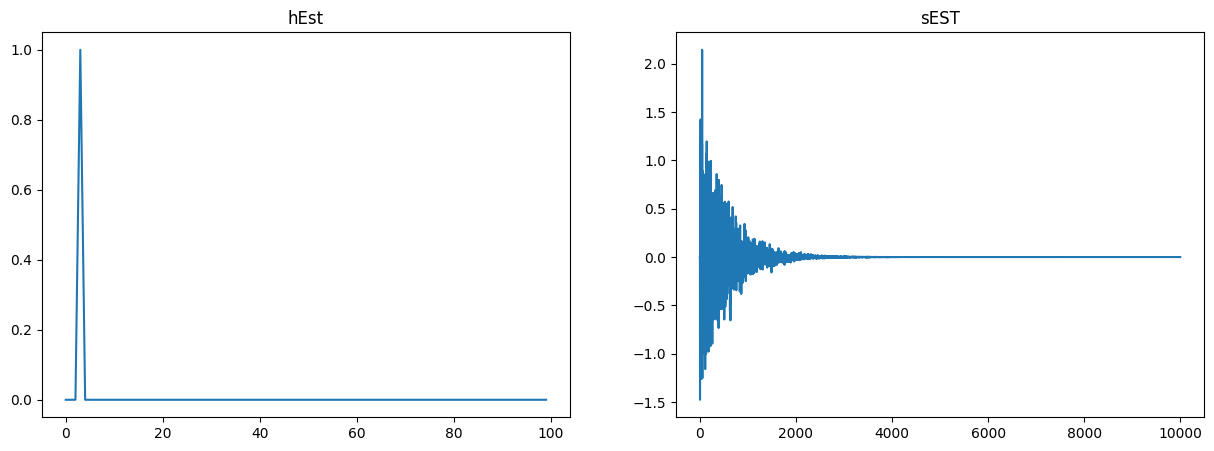

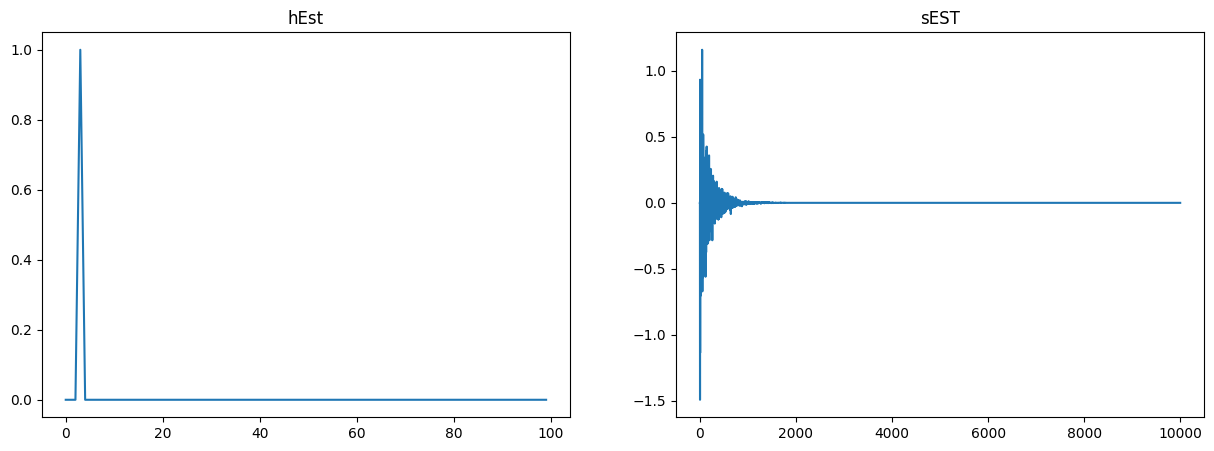

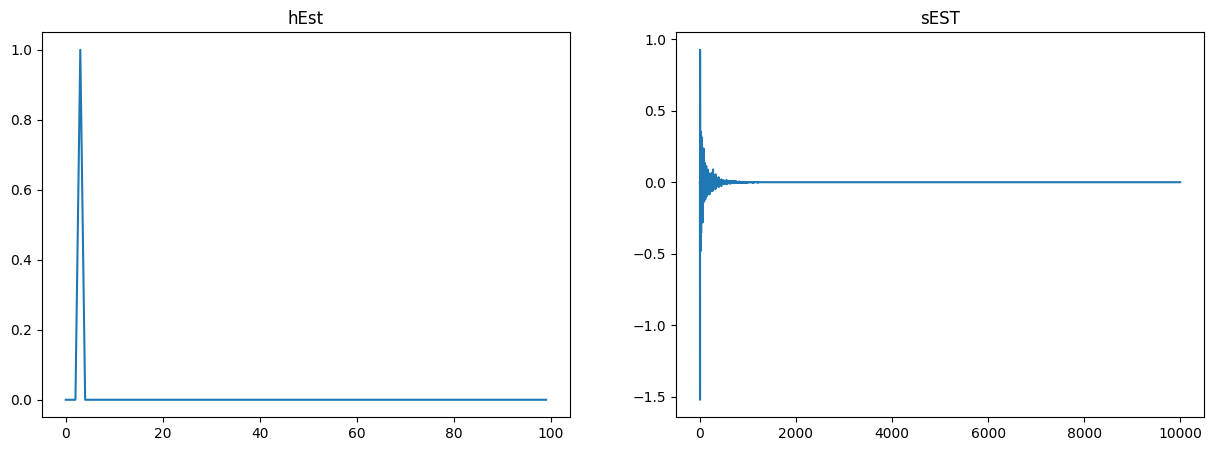

In [39]:
# Test of the NLMSCanceller()

M = 100

for alpha in (0.1, 0.25, 0.5):
    hEst, sEst = NLMSCanceller(x, vprime, alpha, M)

    figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

    ax1.plot(hEst)
    ax1.set_title('hEst')

    ax2.plot(sEst)
    ax2.set_title('sEST')


### Application to real data

Satisfied that we have now implemented the adaptive filter correctly, we shall now apply this to real data (speech corrupted by "echo").

1. Load `adaptive_filter.npz`
2. The variables should be as follows:
  1. $\matcmd[]{x}$: The signal we want to denoise ($x(n) = s(n) + v(n)$)
  2. $\matcmd[]{vprime}$: The reference signal for noise ($v^{\prime}(n)$)
  3. $\matcmd[]{fs}$: The sampling frequency (required to write the processed file as a `.wav` file)

In [54]:
AdaptFiltData = np.load('ex04_nlms_canceller.npz')
print(AdaptFiltData.files) # Tells you the variables in this file. 
# The output should be
# ['x', 'vprime', 'fs', 's']
# The clean signal 's' is the true underlying clean signal and can be used to 
# compare the quality of your implementation.
# 'fs' is the sampling frequency (required to write your output to a .wav file)

x = AdaptFiltData['x']
vprime = AdaptFiltData['vprime']
s = AdaptFiltData['s']
fs = AdaptFiltData['fs']

print(x.size, vprime.size) # See if the signals are the same size.  

['x', 'vprime', 'fs', 's']
62187 62187


<div class="alert alert-info">

**Tasks**
    
1. Select a suitable $M$ and $\alpha$. Selection of these parameters is termed _hyperparameter_ tuning and usually is done by some trial and error. Also, for such applications, the selection of the best parameters is usually a _trade-off_ between the amount of suppression of the unwanted signal and the distortion introduced in the target signal.
2. Process the signal and listen to it (`ipd.Audio(sEst,rate=np.int(fs))` could be a useful function. Alternatively, write your output to a .wav file and listen using any openly available audio processing tool (e.g., Audacity, Ocenaudio,...)). Based on your critical listening, decide the best $M$ and $\alpha$.
3. State the reasons behind your choice of best $M$ and $\alpha$. 
4. Include your processed file (with the selected $M$ and $\alpha$) in the deliverable as: `group_xx_sEst.wav`
    
</div>

In [55]:
# Example to listen to an audio fragment...
ipd.Audio(vprime,rate=int(fs))

In [67]:
# Process the audio
# Find optimal M, alpha 
# For M: start with M = 20 and increase in steps of e.g. 10 until M = 150)
# For alpha consider values such as 0.01,0.1, 0.2, ...

alpha = 0.1
M = 70
hEst, sEst = NLMSCanceller(x, vprime, alpha, M)

# Listen to the outputs if you want to
ipd.Audio(sEst,rate=int(fs))

# When you have the best set of parameters, generate the best output and write to wavfile. 
# Use the line below (after uncommenting, of course!)
# wavfile.write('group_xx_sEst.wav',fs,sEst)

<div class="alert alert-success">
    
Best `M` :
 
Best `alpha`:
    
Why do you think these are the best?

For $\alpha$ we chose a value of ... This is a good trade-off between the speed of convergence and the stability.
    
</div>